# INSIGNEO CORONARY RESISTANCE 2019

## Data Pre-processing

In [2]:
# Importing libraries
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from pandas import ExcelWriter
from pandas import ExcelFile
from math import isnan
from scipy import random, stats
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt

from pylab import rcParams
import seaborn as sb
import scipy
from scipy.stats import spearmanr

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn import datasets

In [3]:
# Importing the data
data_path = "../DATASET/"
data_file_name = "MR_data_Feb19_divided_labels.xlsx"
data_file = data_path + data_file_name
rawdata = pd.read_excel(data_file)
rawdata_array = rawdata.values

## Specify data subsets

In [4]:
# Create a dataframe from the dataset
df = pd.DataFrame(rawdata_array)

# Heading set up
headers = df.iloc[0] # Get headers from DataFrame
headers_list = list(headers) # Make a list from the headers
new_df = pd.DataFrame(df.values[1:],columns=headers_list) # Substitute headers numerical index by header list 

# Create subset for individual diameter columns
DIn = new_df['Inlet diameter'] #Inlet diameter
DOut = new_df['Outlet diameter'] #Outlet diameter
DMin = new_df['Minimum diameter'] #Minimin (stenosis) diameter

# Create subset for myocardial resistance
MR = new_df['Myocardial resistance']

## Scaling data

In this section the data is going to be rescaled for computational purposes.
* At the moment, only the myocardial resistance will be rescaled by 10^(-9)

In [7]:
# Rescaling MR, in this case y1
MR_sfactor = 0.0000000001
MR_scaled = MR*MR_sfactor
#print(MR_scaled)
# Dropping patients with NaN in Myocardial resistance
del MR_scaled[17]
del MR_scaled[24]
del MR_scaled[46]
del MR_scaled[78]
del MR_scaled[80]
del MR_scaled[99]
del MR_scaled[116]
del MR_scaled[127]
del MR_scaled[133]
del MR_scaled[134]
del MR_scaled[137]

MR_df = pd.DataFrame(MR_scaled)

## Dealing with missing data

There will be 2 methods of dealing with this kind of situations:

* Row removal
    * Where the whole row will be discarted
* Mean override
    * Where the value with be substituted with the mean of that particular category(i.e. mean of all LAD/RCA)

### Method 1: Row removal

This causes 11 patients to be removed from the dataset

In [8]:
# Drop NaNs from experimental dataset
DIn_filtered = DIn.dropna() # Drop for Inlet diameter
DOut_filtered = DOut.dropna() # Drop for outlet diameter
DMin_filtered = DMin.dropna() # Drop for minimum diameter

DIn_df =pd.DataFrame(DIn_filtered)
DOut_df =pd.DataFrame(DOut_filtered)
DMin_df =pd.DataFrame(DMin_filtered)

## Statistics

Here, a subset will be created, specified by name, and will be used for statistical analysis of the data

In [9]:
# WORK IN PROGRESS
MR_df.describe()
std1 = MR_scaled.std()
mean1 = MR_scaled.mean()
print('Standard Diviation: ',std1, '\nMean: ',mean1)

Standard Diviation:  1.0993327804438275 
Mean:  1.0290450960027402


In [10]:
# Plotting a histogram to test normality of dataset 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### Normality test

Text(0.5, 1.0, 'Minimum diameter Histogram plot for normality test')

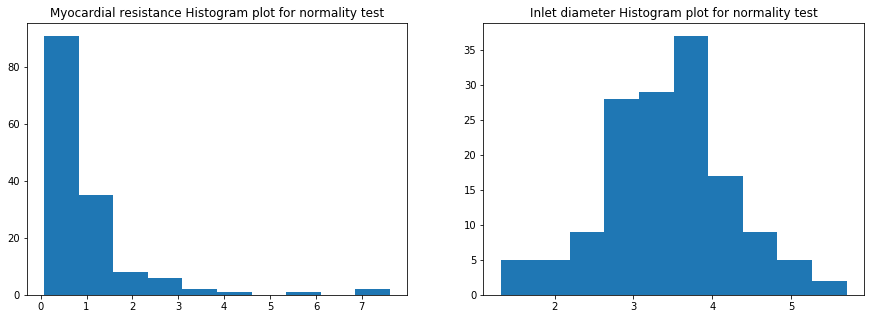

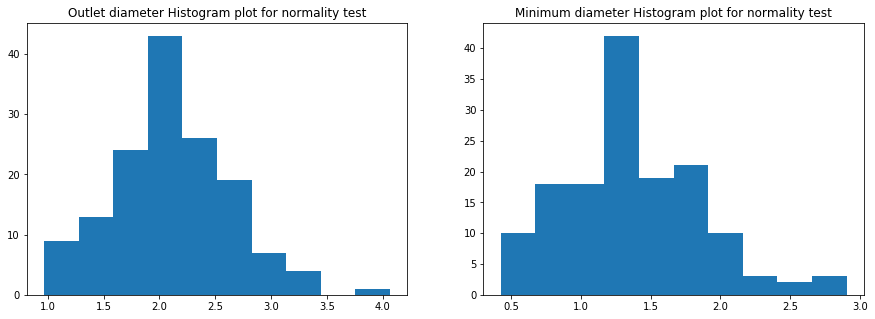

In [11]:
MR_list = list(MR_scaled)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(MR_list)
plt.title('Myocardial resistance Histogram plot for normality test')

DIn_list = list(DIn_filtered)
plt.subplot(1,2,2)
plt.hist(DIn_list)
plt.title('Inlet diameter Histogram plot for normality test')

plt.figure(figsize=(15,5))
DOut_list = list(DOut_filtered)
plt.subplot(1,2,1)
plt.hist(DOut_list)
plt.title('Outlet diameter Histogram plot for normality test')

DMin_list = list(DMin_filtered)
plt.subplot(1,2,2)
plt.hist(DMin_list)
plt.title('Minimum diameter Histogram plot for normality test')

## Multiple LinearRegression Method

In this ML method, I will use the MR as target, and the 3 diameters as training data.

Text(0, 0.5, 'Myocardial resistance')

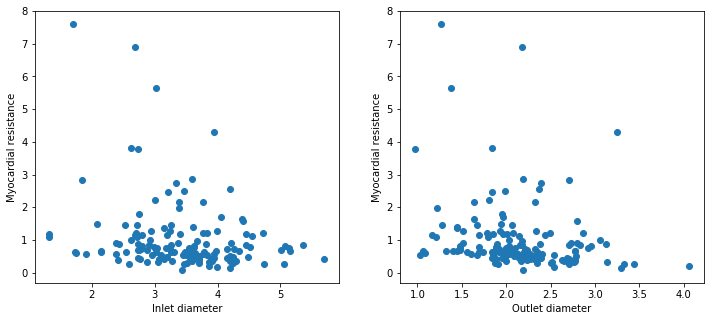

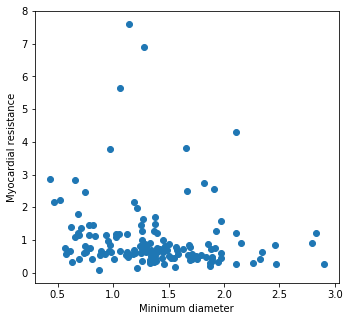

In [12]:
# plot the data
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(DIn_list,MR_list)
plt.xlabel('Inlet diameter')
plt.ylabel('Myocardial resistance')

plt.subplot(1,2,2)
plt.scatter(DOut_list,MR_list)
plt.xlabel('Outlet diameter')
plt.ylabel('Myocardial resistance')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(DMin_list,MR_list)
plt.xlabel('Minimum diameter')
plt.ylabel('Myocardial resistance')

In [13]:
#Model 1
#useful_dataset = new_df.iloc({2,5,6,7})
#print(useful_dataset)
Xr = (MR_df,DIn_df,DOut_df,DMin_df)
model1 = sm.ols(formula= 'MR_list ~ DIn_list + DOut_list + DMin_list', data=MR_df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                MR_list   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     4.171
Date:                Thu, 04 Jul 2019   Prob (F-statistic):            0.00726
Time:                        11:21:35   Log-Likelihood:                -214.32
No. Observations:                 146   AIC:                             436.6
Df Residuals:                     142   BIC:                             448.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6853      0.476      5.636      0.000       1.744       3.627
DIn_list      -0.2562      0.118     -2.179      0.031      -0.489      -0.024
DOut_list     -0.3366      0.186     -1.812      0.072      -0.704       0.031
DMin_list     -0.0439      0.205     -0.215      0.830      -0.449       0.361
==============================================================================
Omnibus:                      129.071   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1323.211
Skew:                           3.295   Prob(JB):                    4.66e-288
Kurtosis:                      16.194   Cond. No.                         24.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(array([67., 51., 13.,  6.,  4.,  1.,  0.,  2.,  0.,  2.]),
 array([-1.04161048, -0.35390844,  0.3337936 ,  1.02149563,  1.70919767,
         2.39689971,  3.08460175,  3.77230379,  4.46000583,  5.14770786,
         5.8354099 ]),
 <a list of 10 Patch objects>)

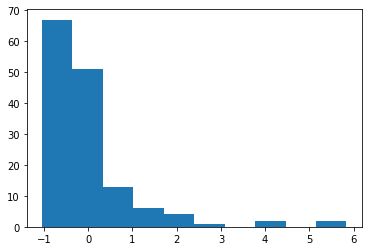

In [14]:
plt.hist(model1.resid)

## Logistic Regression Method

Data Pre-processing
    
    The data needs to be converted to the types that are required for the fit() function in order to have the logistic regression working properly.  

In [15]:
%matplotlib inline
rcParams["figure.figsize"] = 10,5
sb.set_style("whitegrid")

In [17]:
# Data type conversion
Diameter_data = (DIn_filtered.values,DOut_filtered.values,DMin_filtered.values)

D_datav = np.mat(Diameter_data)
D_datavr = D_datav.reshape(-1,3)
D_datavri = D_datavr.astype('int')

MRv = MR_df.values
Y = MRv.reshape(-1,1)
Y = MRv.astype('int')

In [35]:
X = scale(D_datavri)

# create and configure model
LogReg = LogisticRegression(solver='lbfgs',multi_class='auto')

'''' Another method for logistic regression ////////////////////////////////////////////////////////
# Applying Logistic regression
import sklearn.model_selection as LogReg

x_train, x_test, y_train, y_test = LogReg.train_test_split(X, Y, test_size=0.2, random_state=3)

#Reshaping lsts into vectors
x_train_mod = x_train.reshape(-1,3)
x_test_mod = x_test.reshape(-1,3)
y_train_mod = y_train.reshape(-1,1)
y_test_mod = y_test.reshape(-1,1)

#Selecting model
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
print("\nAccuracy score: ",logreg.score(x_train,y_train))////////////////////////////////////////////////////////////////'''''

print(LogReg.fit(X,Y.ravel()))
print("\nAccuracy score: ",LogReg.score(X,Y))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy score:  0.6986301369863014


In [47]:
y_predict = LogReg.predict(X)

from sklearn.metrics import classification_report
report = classification_report(Y,y_predict, labels=np.unique(y_predict))
print(report)

              precision    recall  f1-score   support

           0       0.70      1.00      0.82       102

   micro avg       0.70      1.00      0.82       102
   macro avg       0.70      1.00      0.82       102
weighted avg       0.70      1.00      0.82       102

